In [36]:
import numpy as np
import openai
import pandas as pd
import os
import sys
import time
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import openai
# Add the path to the constants file to the system path
sys.path.append('../../')
from constants import *
from evaluation_utils import *
from path_utils import *
from ChatCompletion_OpenAI_API import *
from CF_utils import *

# OpenAI API Key
openai.api_key = OPENAI_API_KEY

In [37]:
# source code folder path
rec_sys_dir = get_rec_sys_directory()
print(f"Rec-sys directory: {rec_sys_dir}")

# data folder path
DATA_DIR = os.path.join(rec_sys_dir, 'data')
print(f"Data directory: {DATA_DIR}")

# data path
data_path = os.path.join(DATA_DIR, 'amazon-beauty/merged_data.csv')
print(f'Data path: {data_path}')

# zero shot save path
# CF_ZERO_SHOT_SAVE_PATH = os.path.join(DATA_DIR, 'amazon-beauty/CF_small_predictions_zero_shot.csv')
# print(f'Zero shot save path: {CF_ZERO_SHOT_SAVE_PATH}')

# few shot save path
CF_FEW_SHOT_1_OBS_SAVE_PATH = os.path.join(DATA_DIR, 'amazon-beauty/CF_small_1_test_predictions_few_shot.csv')
print(f'Few shot save path: {CF_FEW_SHOT_1_OBS_SAVE_PATH}')

Rec-sys directory: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/rec-sys
Data directory: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/rec-sys/data
Data path: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/rec-sys/data/amazon-beauty/merged_data.csv
Few shot save path: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/rec-sys/data/amazon-beauty/CF_small_1_test_predictions_few_shot.csv


In [91]:
# Read the data
data = pd.read_csv(data_path)

# get statistic and first few data of NUM_SAMPLES rows
data.info()
data.head(NUM_EXAMPLES)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          34 non-null     float64
 1   verified        34 non-null     bool   
 2   reviewTime      34 non-null     object 
 3   reviewerID      34 non-null     object 
 4   asin            34 non-null     object 
 5   reviewerName    34 non-null     object 
 6   reviewText      34 non-null     object 
 7   summary         34 non-null     object 
 8   unixReviewTime  34 non-null     object 
 9   vote            3 non-null      float64
 10  style           17 non-null     object 
 11  category        34 non-null     object 
 12  tech1           0 non-null      float64
 13  description     34 non-null     object 
 14  fit             0 non-null      float64
 15  title           34 non-null     object 
 16  also_buy        34 non-null     object 
 17  tech2           0 non-null      float

,rating,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price
0,5.0,True,2015-09-17,ANV9L0JU6BNL,B000052YAN,Dennis,best floss i've used. does not break as easily...,best floss i've used,2015-09-17,NaN,...,NaN,Reach,[],120.0,"['B01I9TJRN4', 'B003XDVERE', 'B0722XHMGZ', 'B0...",{'\n Product Dimensions: \n ': '1 x 1 x ...,All Beauty,NaN,NaN,5.17
1,5.0,True,2015-09-17,ANV9L0JU6BNL,B000052YAN,Dennis,best floss i've used. does not break as easily...,best floss i've used,2015-09-17,NaN,...,NaN,Reach,[],120.0,"['B01I9TJRN4', 'B003XDVERE', 'B0722XHMGZ', 'B0...",{'\n Product Dimensions: \n ': '1 x 1 x ...,All Beauty,NaN,NaN,5.17
2,2.0,True,2018-03-27,A2TU781PWGS09X,B00006L9LC,Amazon Customer,Doesnt smell,Two Stars,2018-03-27,NaN,...,NaN,Citre Shine,[],1.0,[],"{'ASIN: ': 'B00006L9LC', 'UPC:': '795827187965...",All Beauty,NaN,NaN,23.00
3,2.0,True,2018-03-27,A2TU781PWGS09X,B00006L9LC,Amazon Customer,Doesnt smell,Two Stars,2018-03-27,NaN,...,NaN,Citre Shine,[],1.0,[],"{'ASIN: ': 'B00006L9LC', 'UPC:': '795827187965...",All Beauty,NaN,NaN,23.00
4,5.0,True,2017-02-02,A3A8F2URN7MEPR,B00006L9LC,Sheila T.,My favorite powder!,Five Stars,2017-02-02,NaN,...,NaN,Citre Shine,[],1.0,[],"{'ASIN: ': 'B00006L9LC', 'UPC:': '795827187965...",All Beauty,NaN,NaN,23.00


In [39]:
# Function to create a user-item interaction matrix
def create_interaction_matrix(df, user_col, item_col, rating_col, threshold=0):
    """
    Create the user-item interactions matrix.
    
    :param df: DataFrame containing user-item interactions.
    :param user_col: Name of the user column.
    :param item_col: Name of the item column.
    :param rating_col: Name of the rating column.
    :param threshold: Minimum rating to consider.
    :return: A sparse user-item interaction matrix and mapper dictionaries.
    """
    interactions = df.groupby([user_col, item_col])[rating_col] \
                     .sum().unstack().reset_index(). \
                     fillna(0).set_index(user_col)
    interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    
    user_mapper = dict(zip(np.unique(df[user_col]), list(range(df[user_col].nunique()))))
    item_mapper = dict(zip(np.unique(df[item_col]), list(range(df[item_col].nunique()))))

    user_inv_mapper = dict(zip(list(range(df[user_col].nunique())), np.unique(df[user_col])))
    item_inv_mapper = dict(zip(list(range(df[item_col].nunique())), np.unique(df[item_col])))

    user_index = [user_mapper[i] for i in interactions.index]
    item_index = [item_mapper[i] for i in interactions.columns]

    X = csr_matrix(interactions.values)

    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

# Function to fit the kNN model
def fit_knn_model(interaction_matrix, n_neighbors=4):
    """
    Fit the k-Nearest Neighbors model.
    
    :param interaction_matrix: User-item interaction matrix.
    :param n_neighbors: Number of neighbors to consider.
    :return: Trained kNN model.
    """
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    model_knn.fit(interaction_matrix)
    return model_knn

# Function to find similar users and recommend items
def recommend_items(user_id, interaction_matrix, user_mapper, item_inv_mapper, model_knn, n_recommendations=4):
    """
    Recommend items for a given user.
    
    :param user_id: User ID for whom to make recommendations.
    :param interaction_matrix: User-item interaction matrix.
    :param user_mapper: Dictionary mapping user ID to user index.
    :param item_inv_mapper: Dictionary mapping item index to item ID.
    :param model_knn: Trained kNN model.
    :param n_recommendations: Number of recommendations to make.
    :return: List of recommended item IDs.
    """
    user_idx = user_mapper[user_id]
    distances, indices = model_knn.kneighbors(interaction_matrix[user_idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    recommendations = []
    for i, (idx, dist) in enumerate(raw_recommends):
        if idx != user_idx:  # Skip the user itself
            recommendations.append(item_inv_mapper[idx])

    return recommendations


In [40]:
%%time

# Example DataFrame columns
user_col = 'reviewerID'  # Replace with your user column name
item_col = 'asin'    # Replace with your item column name
rating_col = 'rating' # Replace with your rating column name

# Step 1: Create User-Item Interaction Matrix
interaction_matrix, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_interaction_matrix(data, user_col, item_col, rating_col)

# Step 2: Fit the kNN Model
model_knn = fit_knn_model(interaction_matrix)

# Step 3: Make Recommendations for a specific user
user_id = 'ANV9L0JU6BNL'  # Replace with a user ID from your dataset
recommendations = recommend_items(user_id, interaction_matrix, user_mapper, item_inv_mapper, model_knn, n_recommendations=4)

print("Recommended Items:", recommendations)


Recommended Items: ['B0012Y0ZG2', 'B000URXP6E', 'B00006L9LC', 'B000052YAN']
CPU times: user 13.9 ms, sys: 7.22 ms, total: 21.1 ms
Wall time: 18.7 ms


In [41]:
# Convert a small part of the interaction matrix to a dense format for printing
dense_matrix_sample = pd.DataFrame(interaction_matrix[:10].toarray(), index=user_mapper.keys())
print("User-Item Interaction Matrix (Sample):")
dense_matrix_sample

User-Item Interaction Matrix (Sample):


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
A1U8L4X1O2LXXF,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
A2TU781PWGS09X,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A38IPSLKOQ5O2F,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,1,0,0,1,1,0
A3A8F2URN7MEPR,0,1,1,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ANV9L0JU6BNL,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [42]:
# Create a dense matrix for similarity computation (use with caution for large datasets)
dense_interaction_matrix = interaction_matrix.toarray()

# Compute cosine similarity matrix
user_similarity_matrix = cosine_similarity_manual(dense_interaction_matrix)

# Convert to DataFrame for easier plotting
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_mapper.keys(), columns=user_mapper.keys())


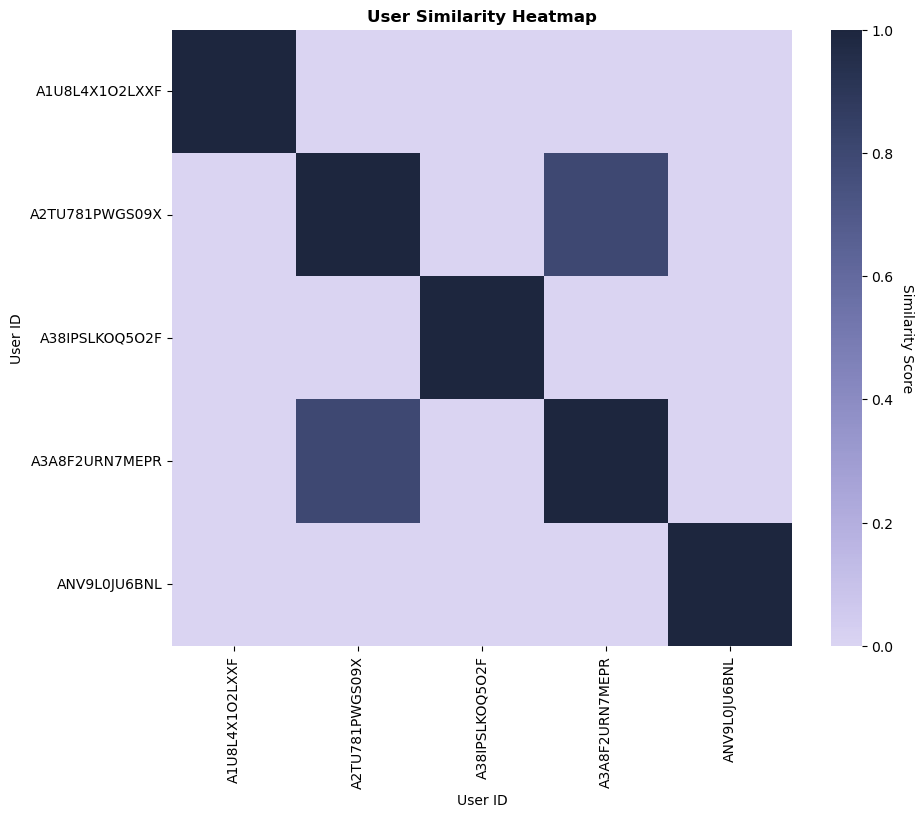

In [43]:
# Customizing the cubehelix palette 
custom_palette = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(user_similarity_df, cmap=custom_palette)
plt.title("User Similarity Heatmap", fontweight='bold')
plt.xlabel("User ID")
plt.ylabel("User ID")

# Adding a title to the color bar
cbar = heatmap.collections[0].colorbar
cbar.set_label('Similarity Score', rotation=270, labelpad=15)

# Save the plot to the images folder
plt.savefig("../images/user_similarity_heatmap.png", bbox_inches='tight')

# Show the plot
plt.show()


# Collaborative filtering model to predict ratings - User based CF

In [99]:
def get_similar_users_ratings(user_id, user_mapper, user_inv_mapper, model_knn, interaction_matrix, data, user_column_name='reviewerID', title_column_name='title'):
    """
    Get ratings from similar users.
    [Function description remains unchanged]
    """
    similar_users_ratings = []
    user_idx = user_mapper.get(user_id)
    
    if user_idx is None:
        return similar_users_ratings

    n_samples = interaction_matrix.shape[0]
    n_neighbors = min(10, n_samples)
    distances, indices = model_knn.kneighbors(interaction_matrix[user_idx], n_neighbors=n_neighbors)

    for idx in indices.flatten():
        if idx == user_idx:
            continue
        similar_user_id = user_inv_mapper[idx]
        similar_user_data = data[data[user_column_name] == similar_user_id]

        for _, row in similar_user_data.iterrows():
            # Skip rows with NaN values in title or rating
            if pd.isna(row[title_column_name]) or pd.isna(row['rating']):
                continue
            similar_users_ratings.append(f"{row[title_column_name]} ({row['rating']} stars)")

    return similar_users_ratings



def predict_ratings_with_collaborative_filtering_and_save(data, interaction_matrix, user_mapper, item_mapper, user_inv_mapper, model_knn,
                                                          columns_for_training, columns_for_prediction,
                                                          user_column_name='reviewerID', title_column_name='title', asin_column_name='asin',
                                                          obs_per_user=None, pause_every_n_users=PAUSE_EVERY_N_USERS, sleep_time=SLEEP_TIME,
                                                          save_path='../../data/amazon-beauty/similar_users_predictions.csv'):
    predicted_ratings = []
    actual_ratings = []
    users = data[user_column_name].unique()

    for idx, user_id in enumerate(users):
        user_data = data[data[user_column_name] == user_id].sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

        if len(user_data) < 5:
            continue  # Skip if there are not enough data points

        for test_idx, test_row in user_data.iterrows():
            # Skip the current item being predicted
            train_data = user_data[user_data[asin_column_name] != test_row[asin_column_name]]

            # Select 'n' distinct previous ratings for training
            n_train_items = min(4, len(train_data))
            if n_train_items == 0:
                continue  # Skip if there are no training items

            train_data = train_data.head(n_train_items)

            # Get similar users' ratings
            similar_users_ratings = get_similar_users_ratings(user_id, user_mapper, user_inv_mapper, model_knn, interaction_matrix, data, columns_for_training, 'title')


            if not similar_users_ratings:
                print(f"No similar users' ratings found for user {user_id}. Skipping prediction.")
                continue

            similar_users_ratings_str = '\n'.join(similar_users_ratings)

            prediction_data = {col: test_row[col] for col in columns_for_prediction if col != 'rating'}
            combined_text = generate_combined_text_for_prediction(columns_for_prediction, *prediction_data.values())

            predicted_rating = predict_rating_combined_ChatCompletion(
                combined_text, 
                rating_history=similar_users_ratings_str, 
                approach="CF"
            )

            product_title = test_row.get(title_column_name, "Unknown Title")
            product_details = f"{product_title}"
            if asin_column_name in test_row:
                product_code = test_row[asin_column_name]
                product_details += f" (Code: {product_code})"

            print(f"Processing user {idx + 1}/{len(users)}, item {test_idx + 1}/{len(user_data)}")
            print(f"User {user_id}:")
            print(f"Rating History for Prediction:\n{similar_users_ratings_str}")
            print(f"Predicted Item: {product_details}")
            print(f"Predicted Rating: {predicted_rating} stars\n")
            print("----------------\n")

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(test_row['rating'])

            if obs_per_user and len(predicted_ratings) >= obs_per_user:
                break  # Break if the observation per user limit is reached

        if (idx + 1) % pause_every_n_users == 0:
            print(f"Processed {idx + 1} users. Pausing for {sleep_time} seconds...")
            time.sleep(sleep_time)

    predicted_ratings_df = pd.DataFrame({'predicted_rating': predicted_ratings, 'actual_rating': actual_ratings})
    predicted_ratings_df.to_csv(save_path, index=False)




In [100]:
user_col = 'reviewerID'   # Column name for users
item_col = 'asin'         # Column name for items
rating_col = 'rating'     # Column name for ratings

# Create User-Item Interaction Matrix
interaction_matrix, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_interaction_matrix(data, user_col, item_col, rating_col)

# Fit the kNN Model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
model_knn.fit(interaction_matrix)


# Columns used for training and prediction
columns_for_training = ITEM_SIDE + USER_SIDE + INTERACTION_SIDE  # Replace with actual column names used for training
columns_for_prediction = ITEM_SIDE  # Replace with actual column names used for prediction


In [101]:
similar_users_ratings = get_similar_users_ratings(user_id, user_mapper, user_inv_mapper, model_knn, interaction_matrix, data, columns_for_training, 'title')
similar_users_ratings

[]

In [102]:
%%time 

predict_ratings_with_collaborative_filtering_and_save(
    data=data,
    interaction_matrix=interaction_matrix,
    user_mapper=user_mapper,
    item_mapper=item_mapper,
    user_inv_mapper=user_inv_mapper,
    model_knn=model_knn,
    columns_for_training=columns_for_training,
    columns_for_prediction=columns_for_prediction,
    user_column_name=user_col,
    title_column_name='title',
    asin_column_name=item_col,
    obs_per_user=1,
    save_path=CF_FEW_SHOT_1_OBS_SAVE_PATH
)


No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user ANV9L0JU6BNL. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction.
No similar users' ratings found for user A2TU781PWGS09X. Skipping prediction

In [ ]:
# Evaluate Few-shot Model
evaluate_model_predictions_rmse_mae(
    data_path=CF_FEW_SHOT_1_OBS_SAVE_PATH,
    num_examples=NUM_EXAMPLES,
    actual_ratings_column='actual_rating',
    predicted_ratings_column='predicted_rating'
)

No valid predictions available for evaluation.
